In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
cd roma/

/Users/thales/roma


In [3]:
run train.py --steps 0 --log_path 1726286401 --path 1722285916


 time_stamp = 1726606802

 data_path: ../data/x_K1.7.0.00_N3153586_c0.75_t1722285916.parquet
 adj_path: ../data/edges_N3153586_c0.75_t1722285916.parquet
 pe_path: ../data/pe_dim1024_N3153586_c0.75_t1722285916.parquet

 Reading PE (LapPE, node2vec) from pe_path... Done.

 Reading graph from data_adj... Done.

 Reading timeseries from data_path... Done.

 Initializing loader and sampling test batch... Done.

 Initializing loader and sampling first training batch... Done.


 MODULE: MODEL[DIMS](curv)
  encoder: HGCN[256, 512]Poi(c=0.125)
  pool:
   pool_0: HGCN[512, 64]
  embed:
   embed_0: HGCN[512, 512]
  decoder: Operator[8192, 6*[1024], 6144] -> [3]
  pde: emergent/Operator[8192, 6*[1024], 6144] -> [1]
    nonlinear[dec,pde]: False,False
    func_space: GRF(l=1.0)
    branch/trunk nets: Transformer/Res
    dual pe: Sequential
    pos_emb_var = [0.1, 0.1], level_emb_var = [1.0]
    time_enc: fourier[2048][t_var=0.0001,x_var=0.0001]

  NUM_PARAMS = 264 M


 x[train] = (3153074, 800), e

In [4]:
batch, loader = get_next_batch(loader, args, data_train)
x_b, adj_b, pe_b = x_test, adj_test, pe_test
#x_b, adj_b, pe_b = pad_graph(x=x[batch.idx.numpy()], adj=batch.edge_index.numpy(), pe=pe[batch.idx.numpy()], x_size=args.batch_size)
#x, adj, pe = pad_graph(batch.x.numpy(), batch.edge_index.numpy(), batch.pe.numpy(), x_size=args.batch_size)

def get_batch(x_b):
    ti = jnp.linspace(args.kappa, T - args.kappa , 20).reshape(-1,1) #jnp.array([4.,5.]).reshape(-1,1)#
    idx = ti.astype(int)
    taus = jnp.arange(1, 1+args.tau_max, 1).astype(int)
    bundles = idx + taus
    yi = x_b[:,bundles].T
    yi = jnp.swapaxes(yi,0,1)
    xi,_ = _batch(x_b, pe_b, idx)
    #xi = _batch(x, pe, idx, sigma=1e-4)

    return xi, yi

def xy_batch(loader):
    batch, loader = get_next_batch(loader, args, data_train)
    x, adj, pe = pad_graph(batch.x.numpy(), batch.edge_index.numpy(), batch.pe.numpy(), x_size=args.batch_size)
    xi, yi = batch(x)
    return xi,yi,loader


xi, yi = get_batch(x_b)

ti = jnp.linspace(args.kappa, T - args.kappa , 20).reshape(-1,1)
idx = ti.astype(int)
#x1, y1 = _batch(x_b, pe_b, idx, key=key)

xi.shape,yi.shape

((20, 512, 1088), (20, 1, 512))

In [5]:
xi[0].shape, adj_b.shape

((512, 1088), (2, 8192))

In [54]:
#def _fwd(ub, adj, t, y, key, mode='train'):
keys = jr.split(prng(),5)
z = model.encode(xi[0], adj_b, key=keys[0])
z, y, loss_pool, S, A = model.renorm(z, adj_b, yi[0], key=keys[1])
x = jnp.zeros((z.shape[0], model.x_dim))
t_ = ti[0] * jnp.ones((z.shape[0],1))
tx = jnp.concatenate([t_,x], axis=-1)
#z_dec, z_pde = model.branch(z, keys[2])

b,z = z[:,:model.kappa],z[:,model.kappa:]
b = model.decoder.func_space(b, keys[0])
pe = jax.vmap(model.decoder.func_pe)(z)
b_dec, attn = model.decoder.branch(b, keys[1], pe=pe, inspect=True)

In [55]:
attn_block = model.decoder.branch.attention_blocks[0]
branch = model.decoder.branch

In [56]:
x = jax.vmap(branch.lin1)(b)
x = jax.vmap(attn_block.layer_norm1)(x)

In [62]:
k = attn_block.attention._project(attn_block.attention.key_proj, x)
q = attn_block.attention._project(attn_block.attention.query_proj, x)
v = attn_block.attention._project(attn_block.attention.value_proj, x)
k.shape, q.shape, v.shape

((576, 8, 128), (576, 8, 128), (576, 8, 128))

In [299]:
import matplotlib.pyplot as plt
from equinox.nn._attention import dot_product_attention, dot_product_attention_weights

plt.rcParams['font.size'] = 20; plt.rcParams['xtick.major.size'] = 8
plt.rcParams['font.family'] = 'STIXgeneral'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.serif'] = 'Computer Modern Roman'

plt.rcParams['figure.figsize'] = [14,11]

In [207]:
a = jax.vmap(dot_product_attention_weights, in_axes=1, out_axes=1)(q,k)
w = jax.vmap(dot_product_attention)(q,k,v)

In [214]:
av = jnp.einsum('ijk,ijl -> ik',a,v)

In [215]:
a.shape, v.shape, w.shape, av.shape

((576, 8, 576), (576, 8, 128), (576, 8, 128), (576, 576))

In [318]:
a_s = jnp.einsum('ijk -> ik',a)
#sns.heatmap(a_s, cmap='rainbow')
a_00, a_11 = a_s[:512,:512], a_s[512:,512:]
a_01, a_10 = a_s[:512,512:], a_s[:512,512:]

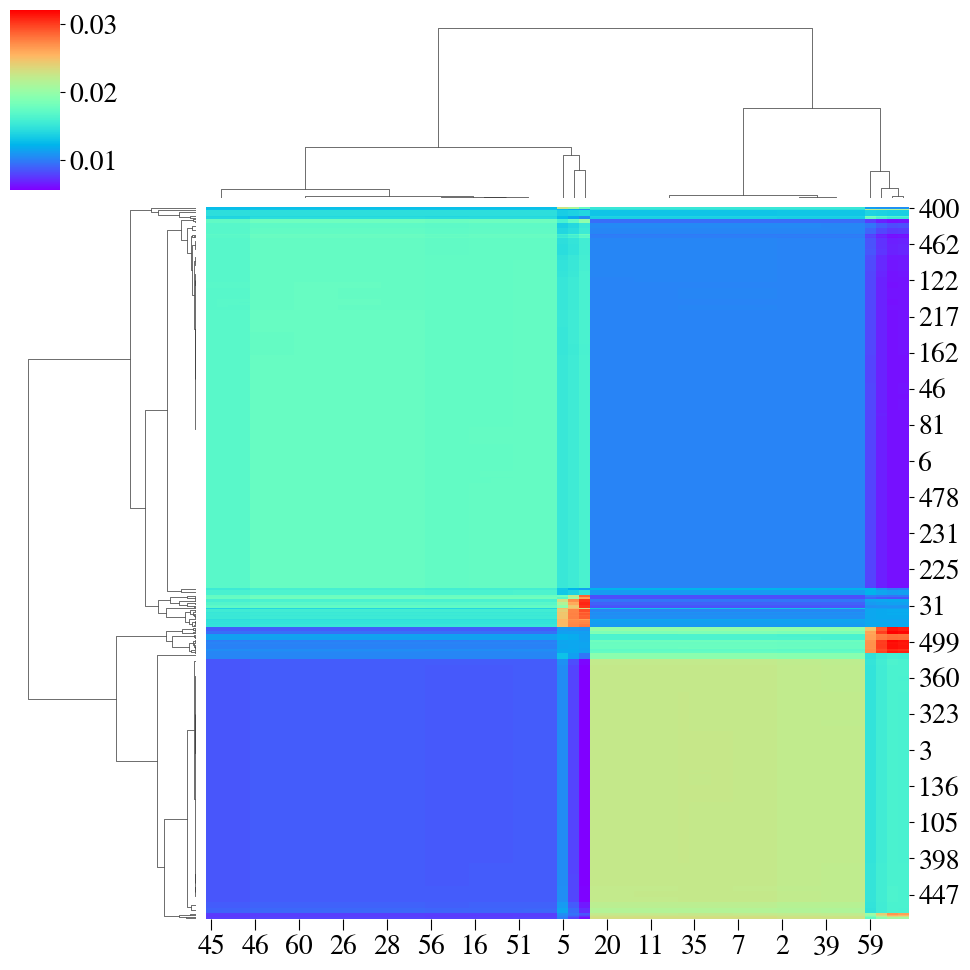

In [320]:
#fig = plt.figure()
#ax = fig.add_subplot(111)
#cms = sns.heatmap(a_s, cmap='rainbow')
plt.rcParams['font.size'] = 20

cm0 = sns.clustermap(a_10, cmap='rainbow')
s,r = cm0.dendrogram_row.reordered_ind, cm0.dendrogram_col.reordered_ind
s,r = np.array(s), np.array(r)

#cm0.ax_row_dendrogram.set_visible(False)
#cm0.ax_col_dendrogram.set_visible(False)

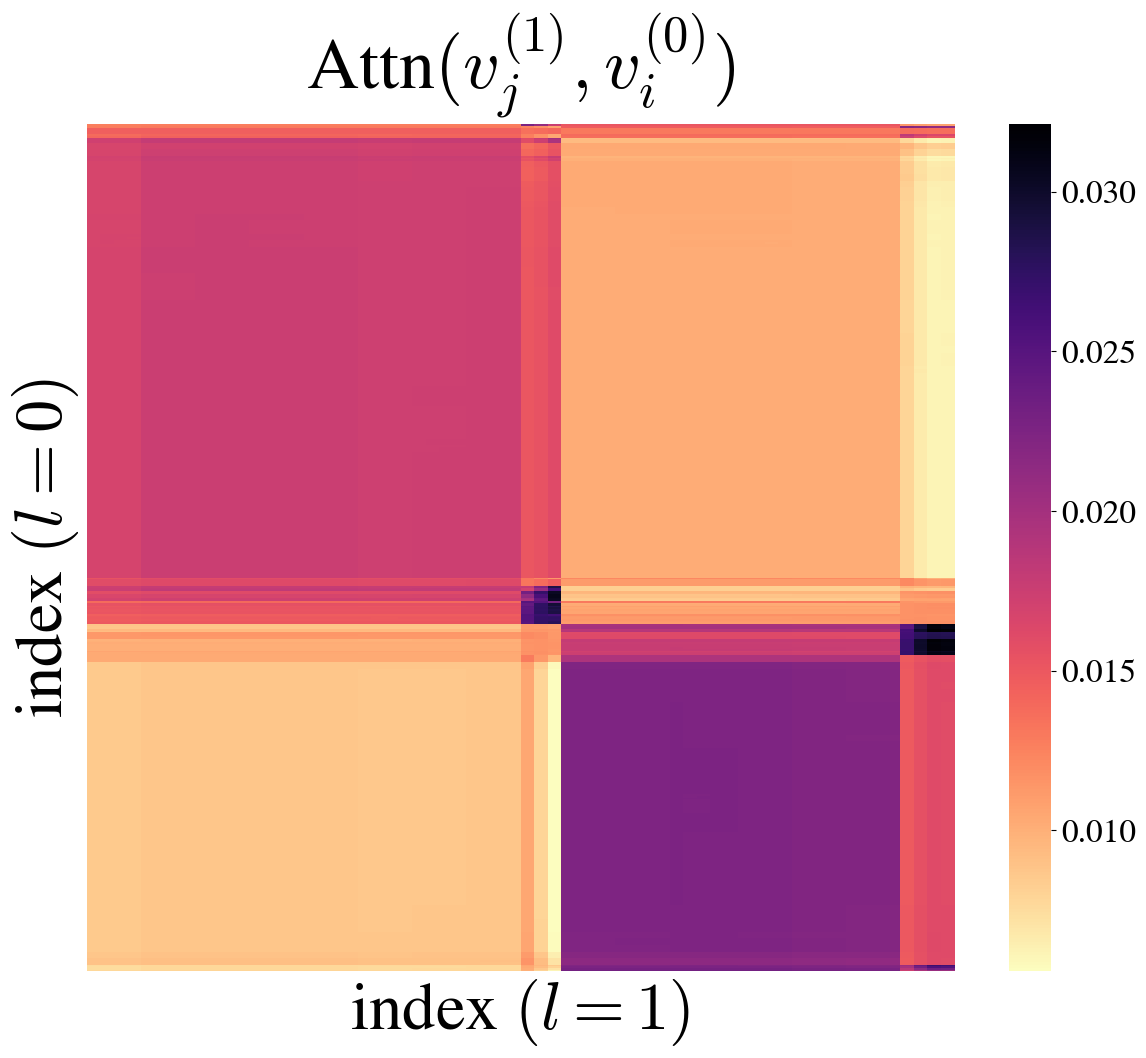

In [413]:
ax = sns.heatmap(a_01[:,r][s], cmap='magma_r')
plt.rcParams['font.size'] = 32
ax.set_ylabel('index $(l=0)$',fontsize=48,rotation=90,labelpad=4)
ax.set_xlabel('index $(l=1)$',fontsize=48)
plt.xticks([])
plt.yticks([])
plt.title('Attn$(v_j^{(1)},v_i^{(0)})$', fontsize=52, pad=26)
plt.savefig('attn_10.pdf')

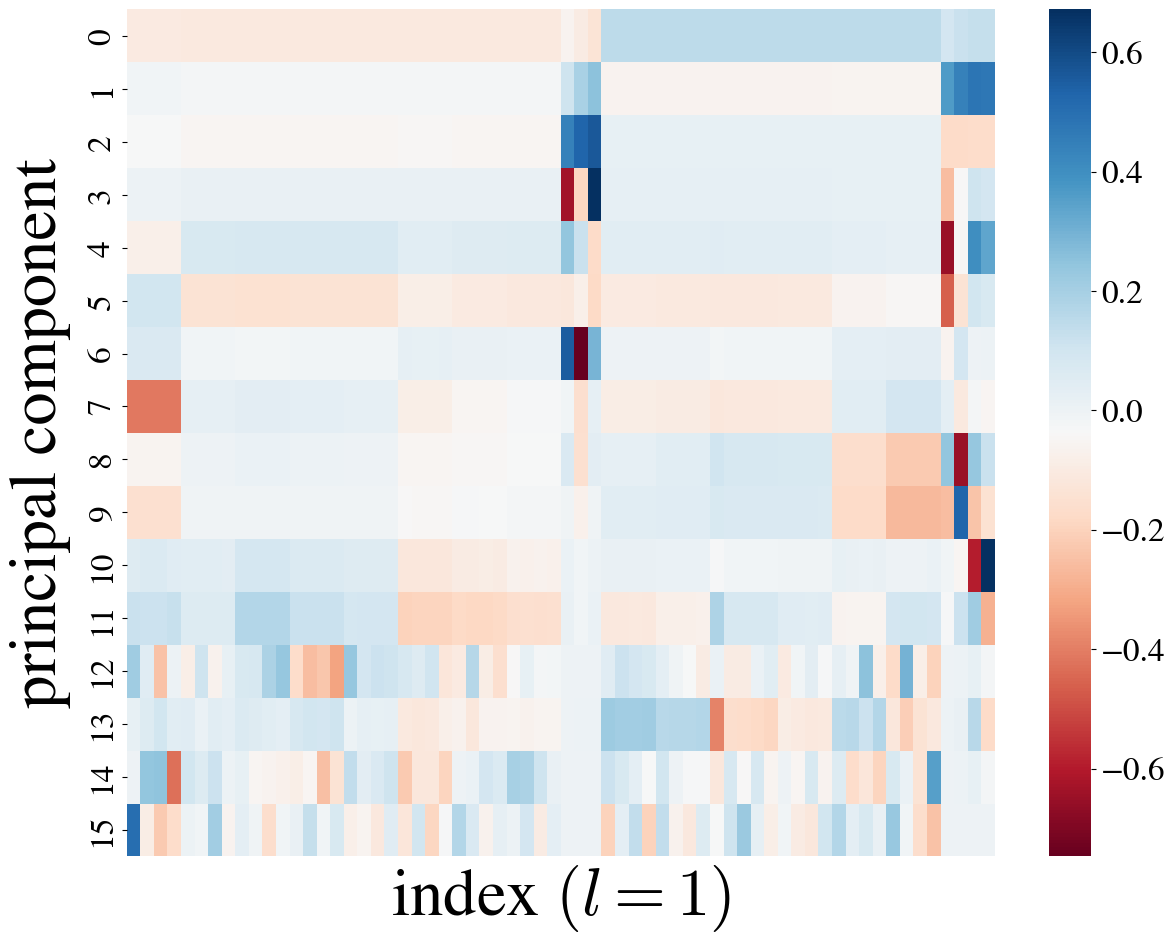

In [414]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD as TSVD
plt.rcParams['font.size'] = 24

A = a_01[:,r][s].T
red = PCA(n_components=64)
red.fit(A.T)
cmp = red.components_
ax = sns.heatmap(cmp[:16],cmap='RdBu')
ax.set_ylabel('principal component',fontsize=48,rotation=90,labelpad=12)
ax.set_xlabel('index $(l=1)$',fontsize=48)
plt.xticks([])
plt.savefig('pca_10.pdf')

<bound method Text.get_color of Text(63.5, 0, '63')>

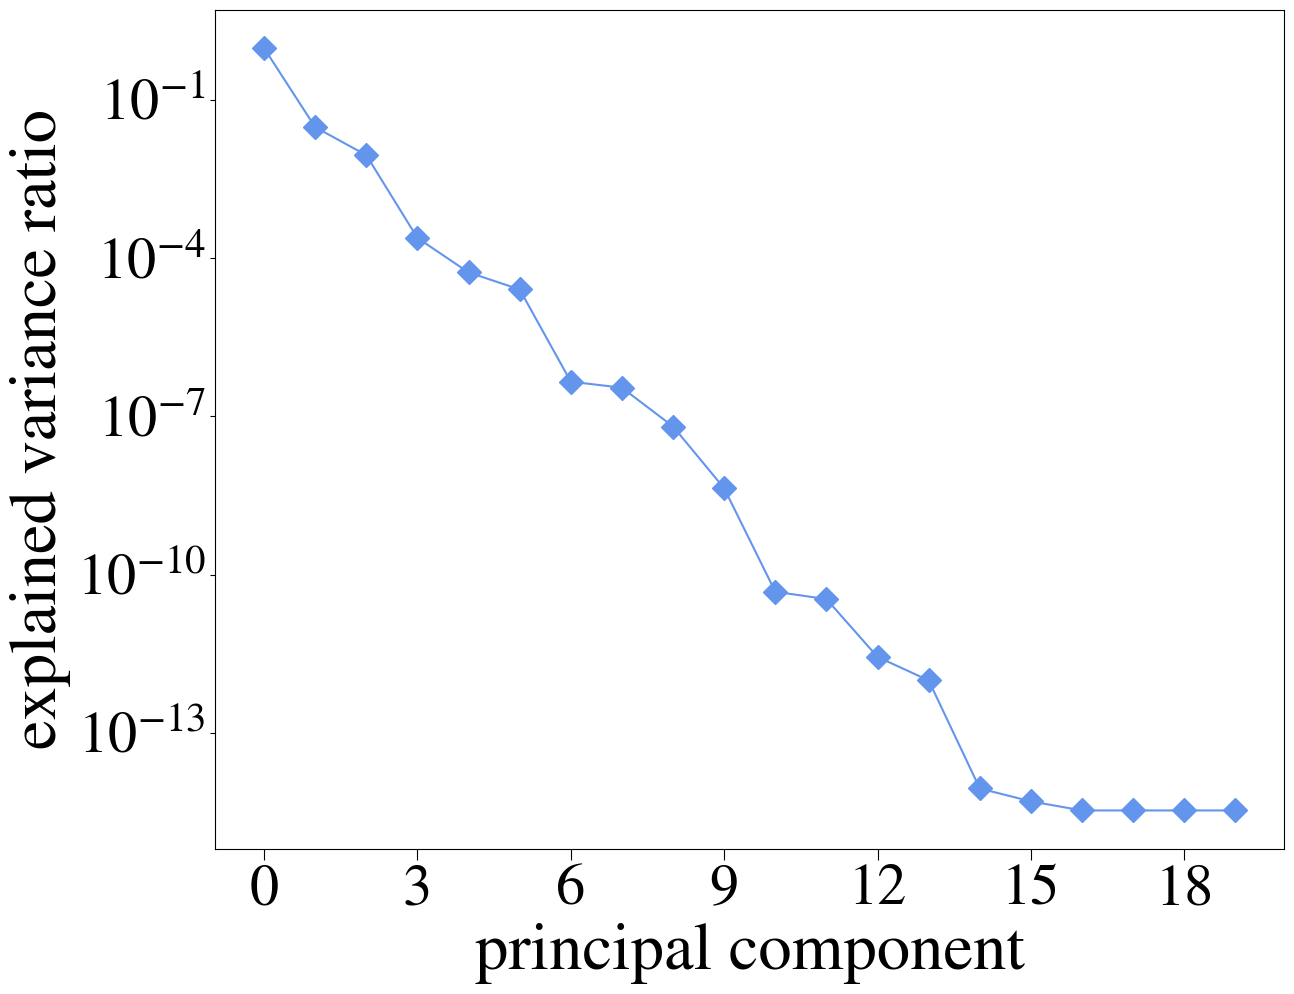

In [339]:
plt.rcParams['font.size'] = 42
ax = pd.DataFrame(red.explained_variance_ratio_[:20]).plot(logy=True,color='cornflowerblue',marker='D',ms=12,legend=None)
ax.set_ylabel('explained variance ratio',fontsize=48,rotation=90,labelpad=4)
ax.set_xlabel('principal component',fontsize=48)
plt.xticks([0,3,6,9,12,15,18])
plt.tight_layout()
plt.savefig('expvar_10.pdf')

<Axes: >

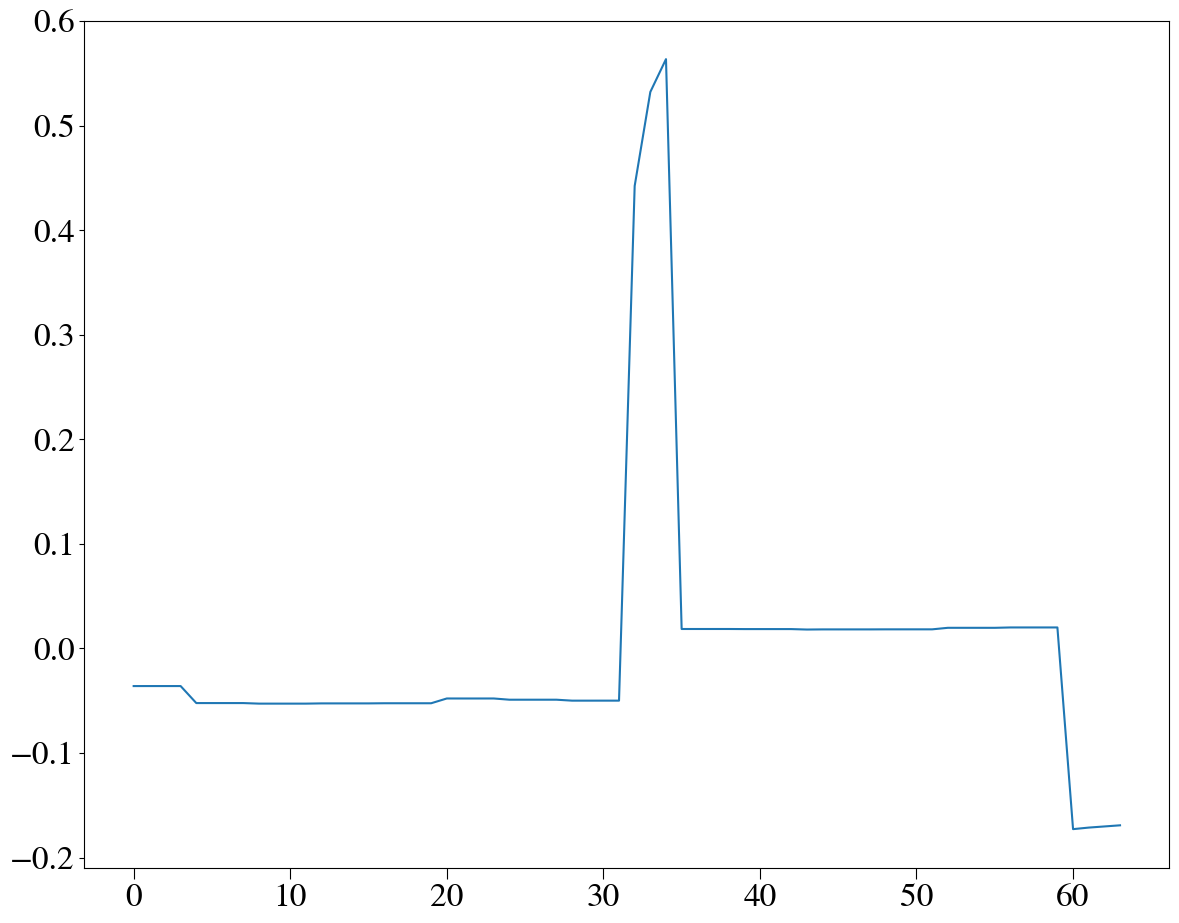

In [373]:
pd.DataFrame(cmp[2].T).plot(legend=False)

In [374]:
c2 = cmp[2]
c2

array([-0.03597653, -0.03596605, -0.03596705, -0.03597116, -0.05223397,
       -0.0522388 , -0.05223619, -0.05223685, -0.0527628 , -0.05276325,
       -0.05276451, -0.0527638 , -0.05253961, -0.05254179, -0.05254001,
       -0.05254142, -0.05240556, -0.05240865, -0.05241022, -0.05240904,
       -0.04784234, -0.04785591, -0.04785716, -0.04784701, -0.04901547,
       -0.04901382, -0.04901478, -0.04901282, -0.04991995, -0.04992077,
       -0.0499085 , -0.04991783,  0.44226065,  0.5321444 ,  0.5635169 ,
        0.01859786,  0.01859823,  0.01859863,  0.01859977,  0.0185178 ,
        0.01851655,  0.01851152,  0.01850884,  0.01808039,  0.01821692,
        0.01821557,  0.01821791,  0.01821538,  0.01826865,  0.01826825,
        0.01827226,  0.01826877,  0.01973216,  0.01973269,  0.01973159,
        0.01972752,  0.02007827,  0.0200752 ,  0.02007675,  0.02007267,
       -0.17278099, -0.17129795, -0.17021433, -0.16912776], dtype=float32)

In [393]:
i,j,k,l = 32,35,60,64
c2[0:i], r[0:i]
c2[i:j], r[i:j]
c2[j:k], r[j:k]
c2[k:l], r[k:l]

(array([-0.17278099, -0.17129795, -0.17021433, -0.16912776], dtype=float32),
 array([59, 23, 14, 41]))

In [397]:
d = {0: r[0:i]+512, 1: r[i:j]+512, 2: r[j:k]+512, 3: r[k:l]+512}
d

{0: array([557, 556, 554, 555, 558, 559, 560, 561, 572, 573, 574, 575, 538,
        537, 536, 539, 540, 541, 542, 543, 568, 570, 567, 569, 528, 527,
        529, 530, 563, 565, 564, 566]),
 1: array([517, 544, 562]),
 2: array([531, 532, 533, 534, 522, 523, 524, 525, 512, 547, 548, 545, 546,
        519, 520, 518, 521, 514, 515, 513, 516, 551, 549, 550, 552]),
 3: array([571, 535, 526, 553])}